In [1]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

H = 300
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5, tanh=False):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
        if tanh:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid()
            )
    def forward(self, input):
        output = self.model(input)
        return output

class DN_LBI(torch.nn.Module):
    def __init__(self, H):
        super(DN_LBI, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 1, bias=True),
        )
        self.out = torch.nn.Sigmoid()
    def forward(self, input):
        output = self.model(input)
        output = self.out(output)
        return output
    def LBI(self, x):
        return self.model(x)

In [3]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
dataset_P = MatConvert(dataset_P, device=device, dtype=dtype)
dataset_Q = MatConvert(dataset_Q, device=device, dtype=dtype)

# 画 p value - n

In [4]:
def get_p(n_train, path, method, force_thres = None):
    if method == 'Scheffe':
        model = Classifier(300, 5).cuda()
    if method == 'Gaussian':
        model = DN(300, 100).cuda()
    if method == 'Fea_Gau':
        model = DN(300, 100).cuda()
    if method == 'Mix':
        model = DN(300, 100).cuda()
    if method == 'LBI':
        model = DN_LBI(300).cuda()
    another_model = another_DN(300, 100).cuda()
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    gc.collect()
    torch.cuda.empty_cache()
    #####################
    p_soft_list = np.zeros(10)
    p_hard_list = np.zeros(10)
    for i in range(10):
        n_eval = min(n,20000)
        n_test = min(n,20000)
        idx = np.random.choice(dataset_P.shape[0]-n_train, n_test+n_eval, replace=False) + n_train
        idy = np.random.choice(dataset_Q.shape[0]-n_train, n_test+n_eval, replace=False) + n_train
        X_eval = dataset_P[0:n_eval]
        Y_eval = dataset_Q[0:n_eval]
        # X_eval = MatConvert(X_eval, device, dtype)
        # Y_eval = MatConvert(Y_eval, device, dtype)
        X_test = dataset_P[idx][n_eval:n_eval+n_test]
        Y_test = dataset_Q[idy][n_eval:n_eval+n_test]
        # X_test = MatConvert(X_test, device, dtype)
        # Y_test = MatConvert(Y_test, device, dtype)
        X_eval_test = X_eval
        Y_eval_test = Y_eval

        if force_thres!= None:
            n_test = X_test.shape[0]
            batch_size = 10000
            X_scores = torch.zeros(n_test)
            Y_scores = torch.zeros(n_test)
            for j in range(1+(n_test-1)//batch_size):
                X_scores[j*batch_size : (j+1)*batch_size] =  compute_score_func(X_test[j*batch_size : (j+1)*batch_size], X_eval, Y_eval,
                                                                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst) 
                Y_scores[j*batch_size : (j+1)*batch_size] =  compute_score_func(Y_test[j*batch_size : (j+1)*batch_size], X_eval, Y_eval,
                                                                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst)
            gc.collect()
            pval = get_pval(X_scores, Y_scores, thres = force_thres, norm_or_binom=False)
            p_soft_list[i] = 0
            p_hard_list[i] = pval
            continue
        
        p_soft = get_pval_at_once(X_eval, Y_eval, X_eval_test, Y_eval_test, X_test, Y_test,
                        model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst,
                        batch_size = 10000,
                        norm_or_binom=True)
        p_hard = get_pval_at_once(X_eval, Y_eval, X_eval_test, Y_eval_test, X_test, Y_test,
                        model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst,
                        batch_size = 10000,
                        norm_or_binom=False)
        p_soft_list[i] = p_soft
        p_hard_list[i] = p_hard
        clear_output(wait=True)
    return p_soft_list, p_hard_list

def get_p_from_10_model(n, method, models = 10, force_thres = None):
    p_soft_mat = np.zeros((models,10))
    p_hard_mat = np.zeros((models,10))
    for i in trange(models):
        path = './'+method+'/checkpoint'+str(n+i+1)+'/0/'
        p_soft_mat[i], p_hard_mat[i] = get_p(n+i+1, path, method, force_thres)
    return p_soft_mat, p_hard_mat


In [5]:
ns = np.array([1300000, 1000000, 700000, 400000, 200000, 50000])

In [ ]:

# for n in ns:
#     ps_L, ps_L_thres = get_p_from_10_model(n, 'Mix', 10)
#     np.save('./Mix/%d_soft.npy'%n, ps_L)
#     np.save('./Mix/%d_hard.npy'%n, ps_L_thres)
#     clear_output(wait=True)



In [7]:
# for n in ns:
#     ps_G, ps_G_thres = get_p_from_10_model(n, 'Fea_Gau', 1)
#     np.save('./Fea_Gau/%d_soft.npy'%n, ps_G)
#     np.save('./Fea_Gau/%d_hard.npy'%n, ps_G_thres)
#     clear_output(wait=True)
# #MMD-G
# # path_dict = {
# #     1300000: './Fea_Gau/checkpoint1300000/35/',
# #     1000000: './Fea_Gau/checkpoint1000000/35/',
# #     700000: './Fea_Gau/checkpoint700000/30/',
# #     400000: './Fea_Gau/checkpoint400000/30/',
# #     100000: './Fea_Gau/checkpoint100000/30/',
# #     50000: './Fea_Gau/checkpoint50000/30/',
# # }
# # ps_G = np.zeros((1,10))
# # ps_G_thres = np.zeros((1,10))
# # method='Fea_Gau'
# # for n in path_dict.keys():
# #     path = path_dict[n]
# #     ps_G, ps_G_thres = get_p(n, path, method)
# #     np.save('./Fea_Gau/%d_soft.npy'%n, ps_G)
# #     np.save('./Fea_Gau/%d_hard.npy'%n, ps_G_thres)


In [8]:
# for n in ns:
#     ps_O, ps_O_thres = get_p_from_10_model(n, 'Gaussian', 10)
#     np.save('./Gaussian/%d_soft.npy'%n, ps_O)
#     np.save('./Gaussian/%d_hard.npy'%n, ps_O_thres)
#     clear_output(wait=True)
# # path_dict = {
# #     1300000: './Gaussian/checkpoint1299999/800/',
# #     1000000: './Gaussian/checkpoint1000000/430/',
# #     700000: './Gaussian/checkpoint700000/20/',
# #     400000: './Gaussian/checkpoint400000/10/',
# #     100000: './Gaussian/checkpoint100000/20/',
# #     50000: './Gaussian/checkpoint50000/40/',
# # }
# # ps_O = np.zeros((1,10))
# # ps_O_thres = np.zeros((1,10))
# # method='Gaussian'
# # for n in path_dict.keys():
# #     path = path_dict[n]
# #     ps_O, ps_O_thres = get_p(n, path, method)
# #     np.save('./Gaussian/%d_soft.npy'%n, ps_O)
# #     np.save('./Gaussian/%d_hard.npy'%n, ps_O_thres)

In [9]:
# for n in ns:
#     ps_S, ps_S_thres = get_p_from_10_model(n, 'Scheffe', 1)
#     np.save('./Scheffe/%d_soft.npy'%n, ps_S)
#     np.save('./Scheffe/%d_hard.npy'%n, ps_S_thres)
#     _, ps_S_thres_05 = get_p_from_10_model(n, 'Scheffe', 1, force_thres=0.5)
#     np.save('./Scheffe/%d_05.npy'%n, ps_S_thres_05)
#     clear_output(wait=True)

time for get thres: 7.200241088867188e-05
time for get scores: 0.22051024436950684
time for get pval: 0.00048351287841796875


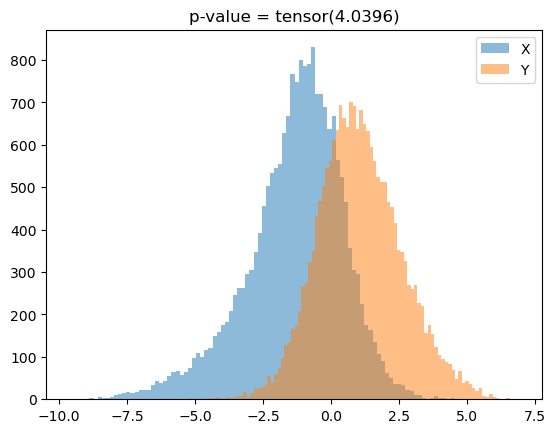

thres= 3.381037410911736 ,max= 7.2025876 ,min= -10.150724
In get_thres(), p-thres.png saved


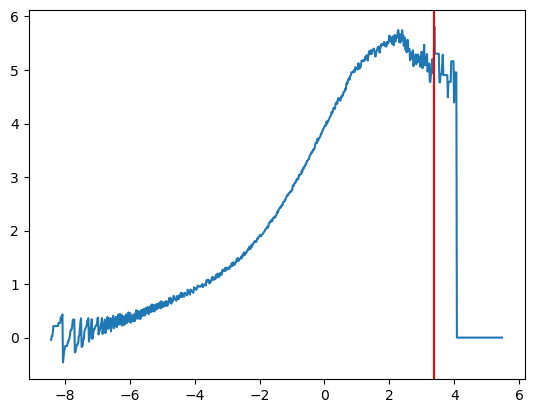

time for get thres: 0.5754773616790771
time for get scores: 0.2151508331298828
time for get pval: 0.0009379386901855469


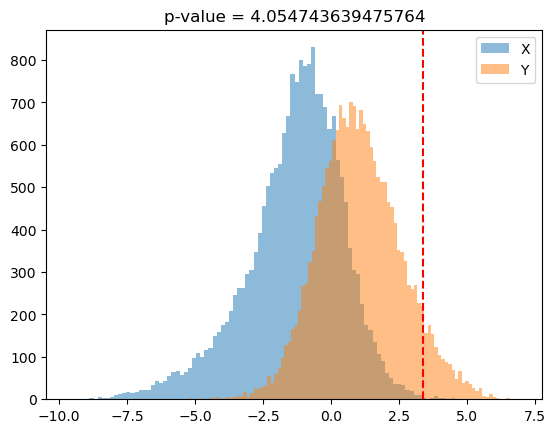

In [18]:
for n in ns:
    ps_B, ps_B_thres = get_p_from_10_model(n, 'LBI', 9)
    np.save('./LBI/%d_soft.npy'%n, ps_B)
    clear_output(wait=True)
